<div style="position: relative;">
<img src="https://user-images.githubusercontent.com/7065401/98728503-5ab82f80-2378-11eb-9c79-adeb308fc647.png"></img>

<h1 style="color: white; position: absolute; top:27%; left:10%;">
     Software Development with Python
</h1>

<h3 style="color: #ef7d22; font-weight: normal; position: absolute; top:55%; left:10%;">
    David Mertz, Ph.D.
</h3>

<h3 style="color: #ef7d22; font-weight: normal; position: absolute; top:62%; left:10%;">
    Data Scientist
</h3>
</div>

# Tracing and Profiling

Within complex programs it can be difficult to get a sense of exactly what paths through the code are actually followed on a particular run.  In fact, one always has a general concern that a project might have "dead code" that is never touched at all.  For that latter concern, the 3rd party tool *Coverage.py* is more focussed (and is recommended in the standard library documentation for the `trace` module.

We do not cover the third party tool in this lesson, but look at the standard library module `trace` and `cProfile`.  Note that the standard library also contains a module called `profile` which is a pure-Python implementation that is compatible with `cProfile`.  However, `profile` adds a very large overhead in times measured, so should only be used in the very specialized case that you wish to extend it.

## Using trace

There are several types of reports that the `trace` module can produce.  Essentially, the module saves information every time a line of code is run.  As you would suspect, this slows down execution quite a lot, but can be useful in analyzing program flow.  Very often, as with `timeit`, `trace` is used from the command line.

Let us look at the timing of every line.  These times, as mentioned, are slowed down by tracing, but their ratios can perhaps be informative.

In [1]:
%%bash
cd ../Fractal
python -m trace --trace --timing \
    ./create-fractal.py -t julia --pixels=50 > fractal-timing.txt

Saved fractal image julia_0_0_2.png


In [2]:
!wc ../Fractal/fractal-timing.txt

  3956268  24862299 257525869 ../Fractal/fractal-timing.txt


In [3]:
!head ../Fractal/fractal-timing.txt

 --- modulename: create-fractal, funcname: <module>
0.01 create-fractal.py(2): "Command line generation of fractals"
0.01 create-fractal.py(4): from argparse import ArgumentParser
0.01 create-fractal.py(5): import sys
0.01 create-fractal.py(6): from PIL import Image
 --- modulename: _bootstrap, funcname: _find_and_load
0.01 <frozen importlib._bootstrap>(988):  --- modulename: _bootstrap, funcname: __init__
0.01 <frozen importlib._bootstrap>(144): 0.01 <frozen importlib._bootstrap>(145):  --- modulename: _bootstrap, funcname: __enter__
0.01 <frozen importlib._bootstrap>(148):  --- modulename: _bootstrap, funcname: _get_module_lock
0.01 <frozen importlib._bootstrap>(163): 0.01 <frozen importlib._bootstrap>(164): 0.01 <frozen importlib._bootstrap>(165): 0.01 <frozen importlib._bootstrap>(166): 0.01 <frozen importlib._bootstrap>(167): 0.01 <frozen importlib._bootstrap>(168): 0.01 <frozen importlib._bootstrap>(170): 0.01 <frozen importlib._bootstrap>(171): 0.01 <frozen importlib._bootstrap>

In [4]:
!tail ../Fractal/fractal-timing.txt

 --- modulename: PngImagePlugin, funcname: _crc32
44.94 PngImagePlugin.py(138):     return zlib.crc32(data, seed) & 0xFFFFFFFF
44.94 PngImagePlugin.py(1019):     fp.write(o32(crc))
 --- modulename: _binary, funcname: o32be
44.94 _binary.py(92):     return pack(">I", i)
44.94 PngImagePlugin.py(1350):     if hasattr(fp, "flush"):
44.94 PngImagePlugin.py(1351):         fp.flush()
44.94 Image.py(2167):             if open_fp:
44.94 Image.py(2168):                 fp.close()
44.94 create-fractal.py(46):     print(f"Saved fractal image {fname}", file=sys.stderr)


In [5]:
!grep 'escape = fn' ../Fractal/fractal-timing.txt | head 

39.97 visualize.py(23):         escape = fn(z0, **kws) or 0
39.97 visualize.py(23):         escape = fn(z0, **kws) or 0
39.97 visualize.py(23):         escape = fn(z0, **kws) or 0
39.97 visualize.py(23):         escape = fn(z0, **kws) or 0
39.97 visualize.py(23):         escape = fn(z0, **kws) or 0
39.97 visualize.py(23):         escape = fn(z0, **kws) or 0
39.97 visualize.py(23):         escape = fn(z0, **kws) or 0
39.97 visualize.py(23):         escape = fn(z0, **kws) or 0
39.97 visualize.py(23):         escape = fn(z0, **kws) or 0
39.97 visualize.py(23):         escape = fn(z0, **kws) or 0
grep: write error: Broken pipe


In less detail, we are likely to be interested just in function calls.

In [6]:
%%bash
cd ../Fractal
python -m trace --trackcalls \
    ./create-fractal.py -t julia --pixels 50 > fractal-calls.txt

Saved fractal image julia_0_0_2.png


In [7]:
!wc ../Fractal/fractal-calls.txt

  18783   52959 1090853 ../Fractal/fractal-calls.txt


In [8]:
!head -20 ../Fractal/fractal-calls.txt


calling relationships:

*** ./create-fractal.py ***
    create-fractal.<module> -> create-fractal.config
    create-fractal.<module> -> create-fractal.main
  --> <frozen importlib._bootstrap>
    create-fractal.<module> -> <frozen importlib._find_and_load
    create-fractal.<module> -> <frozen importlib._handle_fromlist
  --> <string>
    create-fractal.<module> -> <string>.<module>
  --> /home/dmertz/miniconda3/envs/INE/lib/python3.8/argparse.py
    create-fractal.config -> argparse.ArgumentParser.__init__
    create-fractal.config -> argparse.ArgumentParser.parse_args
    create-fractal.config -> argparse._ActionsContainer.add_argument
  --> ./fractal/visualize.py
    create-fractal.generate -> visualize.make_canvas
  --> /home/dmertz/miniconda3/envs/INE/lib/python3.8/site-packages/PIL/Image.py
    create-fractal.generate -> Image.fromarray
  --> /home/dmertz/miniconda3/envs/INE/lib/python3.8/site-packages/numpy/core/_methods.py


In [9]:
!grep 'make_canvas' ../Fractal/fractal-calls.txt

    create-fractal.generate -> visualize.make_canvas
    visualize.make_canvas -> julia.julia


We might wish to look only at the collection of functions that get called.

In [10]:
%%bash
cd ../Fractal
python -m trace --listfuncs \
    ./create-fractal.py -t julia --pixels 50 > fractal-funcs.txt

Saved fractal image julia_0_0_2.png


In [11]:
!wc ../Fractal/fractal-funcs.txt

  7178  43232 990991 ../Fractal/fractal-funcs.txt


In [12]:
!head -25 ../Fractal/fractal-funcs.txt


functions called:
filename: ./create-fractal.py, modulename: create-fractal, funcname: <module>
filename: ./create-fractal.py, modulename: create-fractal, funcname: config
filename: ./create-fractal.py, modulename: create-fractal, funcname: generate
filename: ./create-fractal.py, modulename: create-fractal, funcname: main
filename: ./fractal/__init__.py, modulename: __init__, funcname: <module>
filename: ./fractal/julia.py, modulename: julia, funcname: <module>
filename: ./fractal/julia.py, modulename: julia, funcname: julia
filename: ./fractal/koch.py, modulename: koch, funcname: <module>
filename: ./fractal/mandelbrot.py, modulename: mandelbrot, funcname: <module>
filename: ./fractal/sierpiński.py, modulename: sierpiński, funcname: <module>
filename: ./fractal/visualize.py, modulename: visualize, funcname: <module>
filename: ./fractal/visualize.py, modulename: visualize, funcname: make_canvas
filename: /home/dmertz/miniconda3/envs/INE/lib/python3.8/__future__.py, modulename: __futur

In [13]:
!grep 'filename: \.' ../Fractal/fractal-funcs.txt

filename: ./create-fractal.py, modulename: create-fractal, funcname: <module>
filename: ./create-fractal.py, modulename: create-fractal, funcname: config
filename: ./create-fractal.py, modulename: create-fractal, funcname: generate
filename: ./create-fractal.py, modulename: create-fractal, funcname: main
filename: ./fractal/__init__.py, modulename: __init__, funcname: <module>
filename: ./fractal/julia.py, modulename: julia, funcname: <module>
filename: ./fractal/julia.py, modulename: julia, funcname: julia
filename: ./fractal/koch.py, modulename: koch, funcname: <module>
filename: ./fractal/mandelbrot.py, modulename: mandelbrot, funcname: <module>
filename: ./fractal/sierpiński.py, modulename: sierpiński, funcname: <module>
filename: ./fractal/visualize.py, modulename: visualize, funcname: <module>
filename: ./fractal/visualize.py, modulename: visualize, funcname: make_canvas


You can also call `trace` within Python code.  A switch we did not look at in the above examples is the `--count` options.  That has been approximately replicated as code inside the `create-fractal.py` script itself.  Let us run that and take a look at both the code and the generated files.

In [14]:
%%bash
cd ../Fractal
./create-fractal.py -t julia --pixels 100 --trace

Saved fractal image julia_0_0_2.png


## Using cProfile

By profiling, we can identify "hotspots" and determine which particular function calls are likely to be critical and slow down our program.

In [15]:
import sys
import cProfile
sys.path.append('../Fractal')
from fractal.mandelbrot import mandelbrot, fast_mandelbrot
from fractal.visualize import make_canvas, visualize

Simply profiling a command expressed as a string can produce a lot of output.

In [17]:
#cmd = "visualize(make_canvas(mandelbrot, -1.0, 0.28, 0.15, 800))"
cmd = "make_canvas(mandelbrot, -1.0, 0.28, 0.15, 800)"
cProfile.run(cmd)

         67197043 function calls in 34.053 seconds

   Ordered by: standard name

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000   34.053   34.053 <string>:1(<module>)
   640000   21.995    0.000   32.764    0.000 mandelbrot.py:6(mandelbrot)
        1    1.289    1.289   34.053   34.053 visualize.py:6(make_canvas)
 66557038   10.769    0.000   10.769    0.000 {built-in method builtins.abs}
        1    0.000    0.000   34.053   34.053 {built-in method builtins.exec}
        1    0.000    0.000    0.000    0.000 {built-in method numpy.empty}
        1    0.000    0.000    0.000    0.000 {method 'disable' of '_lsprof.Profiler' objects}




Usually a better approach is to save the results to a file, and use the `pstats` module to filter and sort the results in more helpful ways.

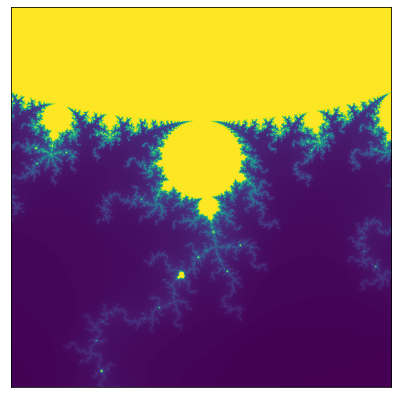

In [18]:
cmd = "visualize(make_canvas(mandelbrot, -1.0, 0.28, 0.15, 800))"
cProfile.run(cmd, "mandelbrot.stats")

In [19]:
import pstats
from pstats import SortKey
p = pstats.Stats('mandelbrot.stats')
p.strip_dirs().sort_stats(SortKey.TIME).print_stats(10)

Thu Jan 28 12:08:27 2021    mandelbrot.stats

         67217390 function calls (67217100 primitive calls) in 31.467 seconds

   Ordered by: internal time
   List reduced from 582 to 10 due to restriction <10>

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
   640000   20.406    0.000   30.322    0.000 mandelbrot.py:6(mandelbrot)
 66557046    9.916    0.000    9.916    0.000 {built-in method builtins.abs}
        1    1.078    1.078   31.400   31.400 visualize.py:6(make_canvas)
      220    0.038    0.000    0.038    0.000 __init__.py:1956(_setattr_cm)
       61    0.002    0.000    0.002    0.000 {method 'reduce' of 'numpy.ufunc' objects}
      358    0.002    0.000    0.002    0.000 {built-in method numpy.array}
       70    0.001    0.000    0.002    0.000 __init__.py:1663(normalize_kwargs)
 1042/853    0.001    0.000    0.001    0.000 artist.py:217(stale)
  200/160    0.001    0.000    0.002    0.000 {built-in method numpy.core._multiarray_umath.implement_ar

In [20]:
p.strip_dirs().sort_stats(SortKey.CALLS).print_callees(20)

   Ordered by: call count
   List reduced from 582 to 20 due to restriction <20>

Function                                           called...
                                                       ncalls  tottime  cumtime
{built-in method builtins.abs}                     -> 
mandelbrot.py:6(mandelbrot)                        -> 66557038    9.916    9.916  {built-in method builtins.abs}
{method 'pop' of 'dict' objects}                   -> 
{built-in method builtins.isinstance}              ->      69    0.000    0.000  abc.py:96(__instancecheck__)
{method 'items' of 'dict' objects}                 -> 
artist.py:217(stale)                               ->     172    0.000    0.000  artist.py:49(_stale_axes_callback)
                                                         1042    0.000    0.000  artist.py:804(get_animated)
                                                           17    0.000    0.000  figure.py:45(_stale_figure_callback)
artist.py:804(get_animated)                   